In [1]:
!pip install langdetect

     |████████████████████████████████| 1.0MB 10.4MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-cp36-none-any.whl size=993460 sha256=96d12ffb82e791f97ecdb0ccaf696708d9b207788bad8638e87a5cb7c2f24c84
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
from langdetect import detect
from tqdm import tqdm
from pathlib import Path
import pickle
import re
import importlib
import os

In [0]:
MAIN_DIR = Path("drive/My Drive/Colab Notebooks/transformers/MoviePlots")

DATA_DIR = MAIN_DIR/"data"
DATA_DIR.mkdir(exist_ok=True)
DATA_FILE = DATA_DIR/'data.pkl'

In [7]:
# Import title_extractor
spec = importlib.util.spec_from_file_location('title_extractor', MAIN_DIR/'title_extractor.py')
title_extractor = importlib.util.module_from_spec(spec)
spec.loader.exec_module(title_extractor)
title_extractor

<module 'title_extractor' from 'drive/My Drive/Colab Notebooks/transformers/MoviePlots/title_extractor.py'>

## Download data

In [8]:
!rm -rf data
!mkdir data
!wget https://github.com/davidsbatista/text-classification/blob/master/movies_genres.csv.bz2?raw=true -O data/movies_genres.csv.bz2

--2019-11-24 21:43:56--  https://github.com/davidsbatista/text-classification/blob/master/movies_genres.csv.bz2?raw=true
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/davidsbatista/text-classification/raw/master/movies_genres.csv.bz2 [following]
--2019-11-24 21:43:57--  https://github.com/davidsbatista/text-classification/raw/master/movies_genres.csv.bz2
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/davidsbatista/text-classification/master/movies_genres.csv.bz2 [following]
--2019-11-24 21:43:57--  https://raw.githubusercontent.com/davidsbatista/text-classification/master/movies_genres.csv.bz2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubuserconte

In [0]:
df = pd.read_csv('data/movies_genres.csv.bz2', sep='\t')

## Prepare data

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117352 entries, 0 to 117351
Data columns (total 30 columns):
title          117352 non-null object
plot           117352 non-null object
Action         117352 non-null int64
Adult          117352 non-null int64
Adventure      117352 non-null int64
Animation      117352 non-null int64
Biography      117352 non-null int64
Comedy         117352 non-null int64
Crime          117352 non-null int64
Documentary    117352 non-null int64
Drama          117352 non-null int64
Family         117352 non-null int64
Fantasy        117352 non-null int64
Game-Show      117352 non-null int64
History        117352 non-null int64
Horror         117352 non-null int64
Lifestyle      117352 non-null int64
Music          117352 non-null int64
Musical        117352 non-null int64
Mystery        117352 non-null int64
News           117352 non-null int64
Reality-TV     117352 non-null int64
Romance        117352 non-null int64
Sci-Fi         117352 non-null int64

### Language

In [11]:
# We want English plots only
plot_langs = []
for plot in tqdm(df['plot']):
    plot_langs.append(detect(plot))

100%|██████████| 117352/117352 [09:11<00:00, 212.66it/s]


In [12]:
df['plot_lang'] = plot_langs
df['plot_lang'].value_counts()

en    117193
nl       120
de        14
it         7
da         6
no         2
pt         2
fr         2
es         2
sl         1
hu         1
ca         1
sv         1
Name: plot_lang, dtype: int64

In [0]:
df = df[df['plot_lang'].isin(['en'])]

In [14]:
df = df.drop(columns=['plot_lang'])

print(df.shape)

(117193, 30)


### Genres

In [15]:
genre_cols = df.columns.difference(['title', 'plot'])

df[genre_cols].sum().sort_values()

Lifestyle          0
Adult             61
Short            578
Musical          595
Biography       1385
War             1407
Sport           1946
Game-Show       2045
Horror          2571
History         2662
Western         2761
Music           2837
News            3945
Talk-Show       5253
Fantasy         7103
Sci-Fi          8658
Thriller        8852
Adventure      10243
Animation      11369
Documentary    12020
Mystery        12025
Reality-TV     12336
Action         12376
Crime          15120
Family         15403
Romance        19174
Comedy         33870
Drama          45890
dtype: int64

In [16]:
# Build list of genres for each row
genre_df = df[genre_cols].astype(bool)
plot_genres = []
for idx, row in tqdm(genre_df.iterrows()):
    plot_genres.append({genre.lower() for genre, isset in row.iteritems() if isset})

117193it [00:09, 12287.90it/s]


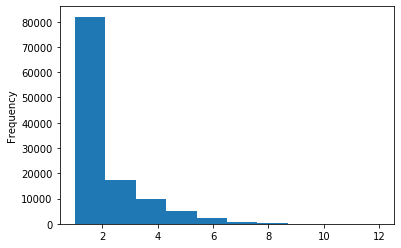

In [17]:
df['genres'] = plot_genres
df['genres'].apply(len).plot.hist()

In [18]:
df = df.drop(columns=genre_cols)

print(df.shape)

(117193, 3)


### Title

In [19]:
# https://help.imdb.com/article/contribution/titles/title-formatting/G56U5ERK7YY47CQB?ref_=helpsect_pro_4_3#
# Extract information from title

df['title'][df['title'].str.contains('Star Wars')].tolist()

['"60 Minutes" (1968) {A New Direction on Drugs/The New Force Behind Star Wars/Lewis Hamilton (#48.13)}',
 '"60 Minutes" (1968) {Ken Lay/Submission/The Last Star Wars (#37.24)}',
 '"Andrew\'s Games" (2016) {Best Zombie Weapons - Minecraft, Star Wars, Halo, Super Mario (#1.10)}',
 '"At the Movies" (1982) {The Secret of \'Star Wars\'}',
 '"Atop the Fourth Wall" (2008) {The Star Wars #1 (#8.9)}',
 '"Atop the Fourth Wall" (2008) {The Star Wars #3 (#9.5)}',
 '"Auction Kings" (2010) {Star Wars Stormtrooper/Mustang Motorcycle (#4.8)}',
 '"Beverly Hills Pawn" (2013) {Star Wars and Chocolate Bars (#1.8)}',
 '"It\'s a Wrap" (2012) {Star Wars Episode 7: Directors List (#1.1)}',
 '"Lego Star Wars: Droid Tales" (2015)',
 '"Star Wars Rebels" (2014)',
 '"Star Wars Rebels" (2014) {Fire Across the Galaxy (#1.14)}',
 '"Star Wars Rebels" (2014) {The Honorable Ones (#2.16)}',
 '"Star Wars: Clone Wars" (2003)',
 '"Star Wars: Clone Wars" (2003) {Chapter 20 (#2.10)}',
 '"Star Wars: Clone Wars" (2003) {Chapte

In [20]:
df['year'] = df['title'].apply(title_extractor.extract_year)
df['year'].describe()

count    116278.000000
mean       1996.543852
std          17.703482
min        1930.000000
25%        1987.000000
50%        2003.000000
75%        2011.000000
max        2022.000000
Name: year, dtype: float64

In [21]:
df['episode'] = df['title'].apply(title_extractor.extract_episode)
df['episode'].describe()

count     101818
unique     10888
top          1.1
freq        3933
Name: episode, dtype: object

In [22]:
df['primary'] = df['title'].apply(title_extractor.extract_primary_title)
df['primary'].describe()

count                117193
unique                20613
top       Days of Our Lives
freq                   1583
Name: primary, dtype: object

In [23]:
df['primary'].value_counts()

Days of Our Lives              1583
Neighbours                     1243
Home and Away                  1106
Thuis                          1080
The Bold and the Beautiful     1003
                               ... 
Crisis PR                         1
Hookers: Saved on the Strip       1
Na Aana Iss Des Laado             1
Kamen Raidâ Bureido               1
Inside the NFL                    1
Name: primary, Length: 20613, dtype: int64

In [24]:
df['secondary'] = df['title'].apply(title_extractor.extract_secondary_title)
df['secondary'].describe()

count     103805
unique     74168
top             
freq       19507
Name: secondary, dtype: object

In [25]:
df['secondary'].value_counts()

                         19507
Pilot                      396
Reunion                     36
The Wedding                 27
Homecoming                  26
                         ...  
Daddy Knows Best             1
Mufasa                       1
Tussen hemel en aarde        1
Maritime Mysteries           1
El sueño de la razón         1
Name: secondary, Length: 74168, dtype: int64

In [26]:
df.head()

,title,plot,genres,year,episode,primary,secondary
0,"""#7DaysLater"" (2013)",#7dayslater is an interactive comedy series f...,{comedy},2013.0,None,#7DaysLater,None
1,"""#BlackLove"" (2015) {Crash the Party (#1.9)}","With just one week left in the workshops, the...",{reality-tv},2015.0,1.9,#BlackLove,Crash the Party
2,"""#BlackLove"" (2015) {Making Lemonade Out of Le...",All of the women start making strides towards...,{reality-tv},2015.0,1.2,#BlackLove,Making Lemonade Out of Lemons
3,"""#BlackLove"" (2015) {Miss Independent (#1.5)}",All five of these women are independent and s...,{reality-tv},2015.0,1.5,#BlackLove,Miss Independent
4,"""#BlackLove"" (2015) {Sealing the Deal (#1.10)}",Despite having gone through a life changing p...,{reality-tv},2015.0,1.10,#BlackLove,Sealing the Deal


In [27]:
data = []
for idx, row in tqdm(df.iterrows()):
    data.append(row.to_dict())

117193it [00:14, 8276.96it/s]


In [0]:
# Save data to disk
with open(DATA_FILE, "wb") as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)